## Начальная установка

In [1]:
#@title Установка библиотек
!pip install -qq diffusers["training"]==0.4.1 transformers ftfy
!pip install -qq "ipywidgets>=7,<8"

     |████████████████████████████████| 229 kB 31.0 MB/s 
     |████████████████████████████████| 5.3 MB 65.3 MB/s 
     |████████████████████████████████| 53 kB 1.9 MB/s 
     |████████████████████████████████| 163 kB 71.9 MB/s 
     |████████████████████████████████| 441 kB 53.7 MB/s 
     |████████████████████████████████| 148 kB 58.3 MB/s 
     |████████████████████████████████| 7.6 MB 55.5 MB/s 
     |████████████████████████████████| 212 kB 73.5 MB/s 
     |████████████████████████████████| 115 kB 76.6 MB/s 
     |████████████████████████████████| 127 kB 73.3 MB/s 
     |████████████████████████████████| 1.6 MB 27.7 MB/s 


In [2]:
#@title Добавление необходимых библиотек
import argparse
import itertools
import math
import os
import random

import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from torch.utils.data import Dataset

import PIL
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.hub_utils import init_git_repo, push_to_hub
from diffusers.optimization import get_scheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

## Настройки для обучения новой концепции

In [3]:
#@markdown `pretrained_model_name_or_path` какую контрольную точку Stable Diffusion вы хотите использовать
pretrained_model_name_or_path = "CompVis/stable-diffusion-v1-4" #@param {type:"string"}

In [15]:
#@markdown URL картинки, 3-5 будет достаточно.
urls = [
      "https://lh5.googleusercontent.com/vIKiHK_pFKCTYbaw_LoPmj5odqNd_EmnOnGML1G_uUK6GczyMlvU8rl6MM0O7SlEpn4=w2400", 
      "https://lh6.googleusercontent.com/sLTxRuGHd-wRGKKqKxyfViSkWydCkO44ZY_b7GOwXSfc6rsDtTw6wGgwOoA-r2B_pGY=w2400", 
      "https://lh5.googleusercontent.com/Q3mGsUBxudbQgJakN2JRzUodZkeAx-olWvsBB2iNOXcU0Q0Y9b0z2CyYSmb2ZSQ6OF8=w2400", 
      "https://lh5.googleusercontent.com/8a4uB-JDKhN66dN2EmvB5hm_rGGTntcLvAZV74IcmSm5hoyA5MknQiiWPRzY6Nsk6eA=w2400",
      ## Тут можно добавить изображения
      ]

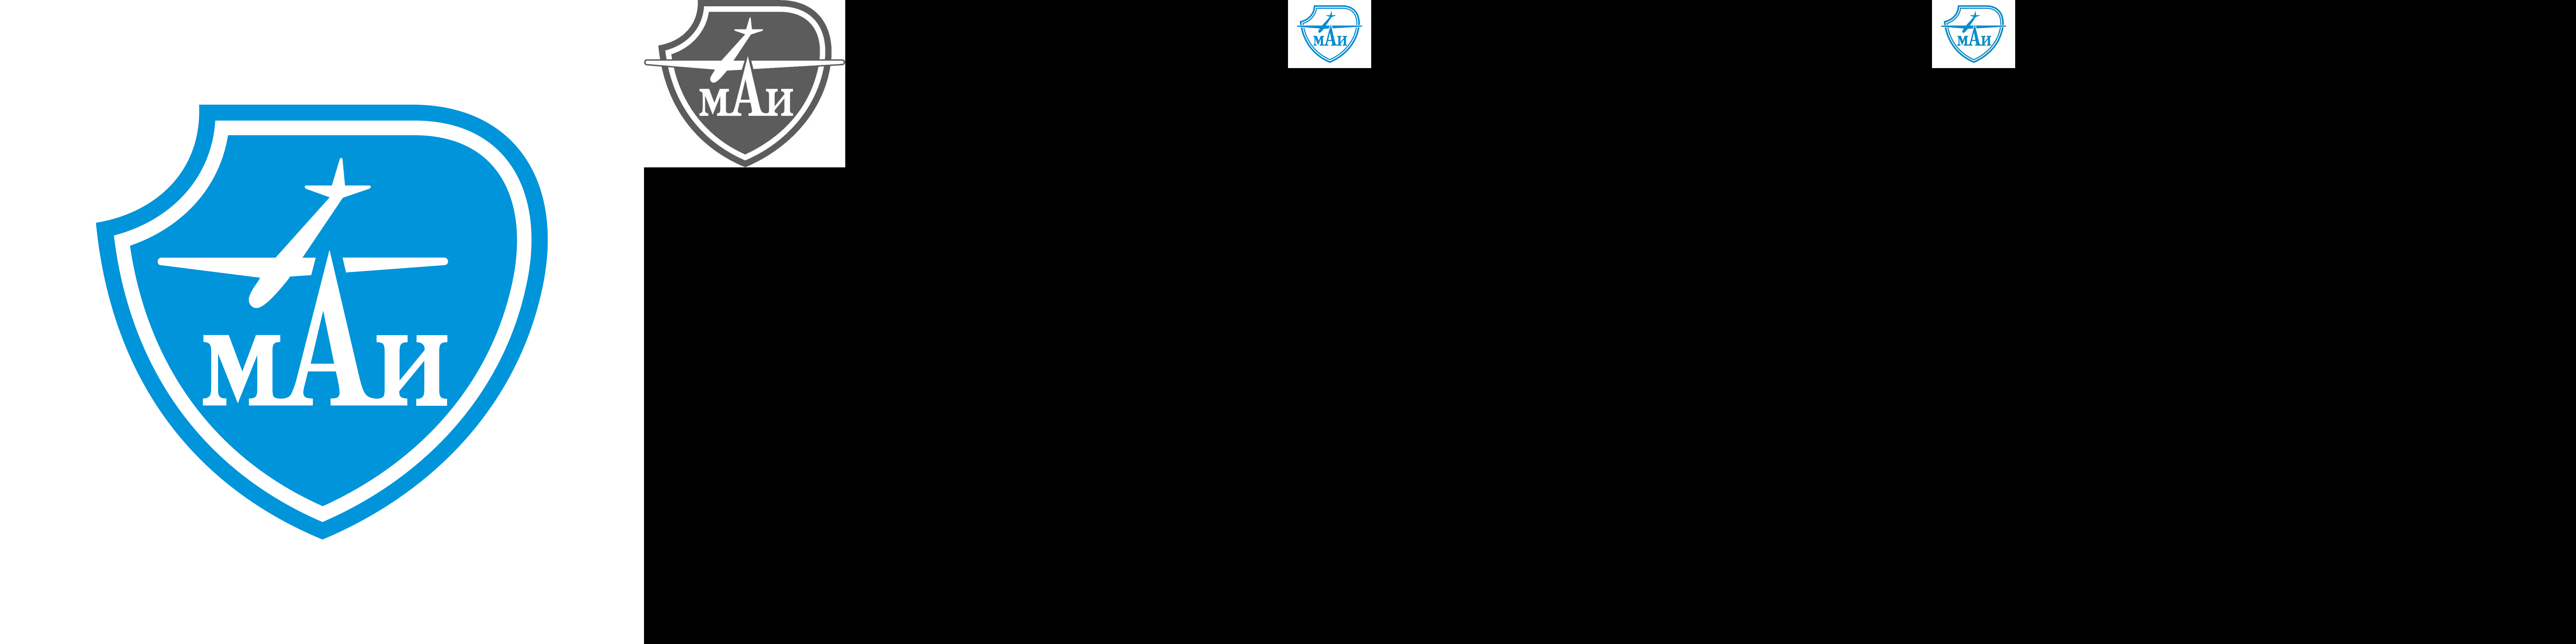

In [21]:
#@title Установите и проверьте изображения, которые вы только что добавили
import requests
import glob
from io import BytesIO

def download_image(url):
  try:
    response = requests.get(url)
  except:
    return None
  return Image.open(BytesIO(response.content)).convert("RGB")

images = list(filter(None,[download_image(url) for url in urls]))
save_path = "./my_concept"
if not os.path.exists(save_path):
  os.mkdir(save_path)
[image.save(f"{save_path}/{i}.jpeg") for i, image in enumerate(images)]
image_grid(images, 1, len(images))

In [17]:
#@title Настройки для только что созданной концепции
#@markdown `what_to_teach`: чему вы учите? `object` позволяет обучить модель новому объекту, который будет использоваться, `style` позволяет обучить модель новому стилю, который можно использовать.
what_to_teach = "object" #@param ["object", "style"]
#@markdown `placeholder_token` это токен, который вы собираетесь использовать для представления вашей новой концепции (поэтому, когда вы подсказываете модели, вы говорите "A `<my-placeholder-token>` in an amusement park"). Мы используем угловые скобки, чтобы отличить токен от других слов/токенов, чтобы избежать конфликта.
placeholder_token = "\u003Cmai-logo>" #@param {type:"string"}
#@markdown `initializer_token` слово, которое может кратко описать суть вашей новой концепции, чтобы использовать его в качестве начальной точки.
initializer_token = "logo" #@param {type:"string"}

## Обучить модель новому концепту (тонкая настройка с помощью текстовой инверсии)
Выполните эту последовательность ячеек, чтобы запустить процесс обучения. Весь процесс может занять от 1 до 4 часов. (Откройте этот блок, если вам интересно, как этот процесс работает под капотом, или если вы хотите изменить расширенные настройки обучения или гиперпараметры)

### Создание Dataset-а

In [18]:
#@title Настройка шаблонов подсказок для обучения 
imagenet_templates_small = [
    "a photo of a {}",
    "a rendering of a {}",
    "a cropped photo of the {}",
    "the photo of a {}",
    "a photo of a clean {}",
    "a photo of a dirty {}",
    "a dark photo of the {}",
    "a photo of my {}",
    "a photo of the cool {}",
    "a close-up photo of a {}",
    "a bright photo of the {}",
    "a cropped photo of a {}",
    "a photo of the {}",
    "a good photo of the {}",
    "a photo of one {}",
    "a close-up photo of the {}",
    "a rendition of the {}",
    "a photo of the clean {}",
    "a rendition of a {}",
    "a photo of a nice {}",
    "a good photo of a {}",
    "a photo of the nice {}",
    "a photo of the small {}",
    "a photo of the weird {}",
    "a photo of the large {}",
    "a photo of a cool {}",
    "a photo of a small {}",
]

imagenet_style_templates_small = [
    "a painting in the style of {}",
    "a rendering in the style of {}",
    "a cropped painting in the style of {}",
    "the painting in the style of {}",
    "a clean painting in the style of {}",
    "a dirty painting in the style of {}",
    "a dark painting in the style of {}",
    "a picture in the style of {}",
    "a cool painting in the style of {}",
    "a close-up painting in the style of {}",
    "a bright painting in the style of {}",
    "a cropped painting in the style of {}",
    "a good painting in the style of {}",
    "a close-up painting in the style of {}",
    "a rendition in the style of {}",
    "a nice painting in the style of {}",
    "a small painting in the style of {}",
    "a weird painting in the style of {}",
    "a large painting in the style of {}",
]

In [52]:
#@title Настройка dataset-а
class TextualInversionDataset(Dataset):
    def __init__(
        self,
        data_root,
        tokenizer,
        learnable_property="object",  # [object, style]
        size=512,
        repeats=100,
        interpolation="bicubic",
        flip_p=0.5,
        set="train",
        placeholder_token="*",
        center_crop=False,
    ):

        self.data_root = data_root
        self.tokenizer = tokenizer
        self.learnable_property = learnable_property
        self.size = size
        self.placeholder_token = placeholder_token
        self.center_crop = center_crop
        self.flip_p = flip_p

        self.image_paths = [os.path.join(self.data_root, file_path) for file_path in os.listdir(self.data_root)]
        self.image_paths = [i for i in self.image_paths if os.path.isfile(i)]
        
        self.num_images = len(self.image_paths)
        self._length = self.num_images

        if set == "train":
            self._length = self.num_images * repeats

        self.interpolation = {
            "linear": PIL.Image.LINEAR,
            "bilinear": PIL.Image.BILINEAR,
            "bicubic": PIL.Image.BICUBIC,
            "lanczos": PIL.Image.LANCZOS,
        }[interpolation]

        self.templates = imagenet_style_templates_small if learnable_property == "style" else imagenet_templates_small
        self.flip_transform = transforms.RandomHorizontalFlip(p=self.flip_p)

    def __len__(self):
        return self._length

    def __getitem__(self, i):
        example = {}
        image = Image.open(self.image_paths[i % self.num_images])

        if not image.mode == "RGB":
            image = image.convert("RGB")

        placeholder_string = self.placeholder_token
        text = random.choice(self.templates).format(placeholder_string)

        example["input_ids"] = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
            return_tensors="pt",
        ).input_ids[0]

        # default to score-sde preprocessing
        img = np.array(image).astype(np.uint8)

        if self.center_crop:
            crop = min(img.shape[0], img.shape[1])
            h, w, = (
                img.shape[0],
                img.shape[1],
            )
            img = img[(h - crop) // 2 : (h + crop) // 2, (w - crop) // 2 : (w + crop) // 2]

        image = Image.fromarray(img)
        image = image.resize((self.size, self.size), resample=self.interpolation)

        image = self.flip_transform(image)
        image = np.array(image).astype(np.uint8)
        image = (image / 127.5 - 1.0).astype(np.float32)

        example["pixel_values"] = torch.from_numpy(image).permute(2, 0, 1)
        return example

### Настройка модели

In [53]:
#@title Логин в Hugging Face
#@markdown Add a token with the "Write Access" role to be able to add your trained concept to the [Library of Concepts](https://huggingface.co/sd-concepts-library)
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


In [38]:
#@title Загрузите tokenizer и добавьте маркер placeholder в качестве дополнительного специального маркера.
#@markdown Пожалуйста, прочитайте и, если вы согласны, примите ЛИЦЕНЗИЮ [здесь](https://huggingface.co/CompVis/stable-diffusion-v1-4) если вы видите ошибку

tokenizer = CLIPTokenizer.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="tokenizer",
)

# Add the placeholder token in tokenizer
num_added_tokens = tokenizer.add_tokens(placeholder_token)
if num_added_tokens == 0:
    raise ValueError(
        f"The tokenizer already contains the token {placeholder_token}. Please pass a different"
        " `placeholder_token` that is not already in the tokenizer."
    )

In [39]:
#@title Получите идентификаторы токенов для наших маркеров placeholder и initializer. Этот блок кода будет жаловаться, если строка инициализатора не является одним токеном.
# Convert the initializer_token, placeholder_token to ids
token_ids = tokenizer.encode(initializer_token, add_special_tokens=False)
# Check if initializer_token is a single token or a sequence of tokens
if len(token_ids) > 1:
    raise ValueError("The initializer token must be a single token.")

initializer_token_id = token_ids[0]
placeholder_token_id = tokenizer.convert_tokens_to_ids(placeholder_token)

In [25]:
#@title Загрузить модель стабильной диффузии
# Load models and create wrapper for stable diffusion
text_encoder = CLIPTextModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="text_encoder"
)
vae = AutoencoderKL.from_pretrained(
    pretrained_model_name_or_path, subfolder="vae"
)
unet = UNet2DConditionModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="unet"
)

Downloading:   0%|          | 0.00/592 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/492M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/522 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/743 [00:00<?, ?B/s]

Мы добавили `placeholder_token` в `tokenizer`, поэтому мы изменим размер вложений токенов здесь, это создаст новый вектор вложений в вложениях токенов для нашего ` placeholder_token`.

In [40]:
text_encoder.resize_token_embeddings(len(tokenizer))

Embedding(49409, 768)

 Инициализируйте недавно добавленный токен-заполнитель с помощью вложений токена инициализатора

In [41]:
token_embeds = text_encoder.get_input_embeddings().weight.data
token_embeds[placeholder_token_id] = token_embeds[initializer_token_id]

В Textual-Inversion мы обучаем только вновь добавленный вектор встраивания, поэтому остальные параметры модели здесь можно заморозить

In [42]:
def freeze_params(params):
    for param in params:
        param.requires_grad = False

# Freeze vae and unet
freeze_params(vae.parameters())
freeze_params(unet.parameters())
# Freeze all parameters except for the token embeddings in text encoder
params_to_freeze = itertools.chain(
    text_encoder.text_model.encoder.parameters(),
    text_encoder.text_model.final_layer_norm.parameters(),
    text_encoder.text_model.embeddings.position_embedding.parameters(),
)
freeze_params(params_to_freeze)

### Формирование наших учебных данных

Создадим Dataset и Dataloader

In [54]:
train_dataset = TextualInversionDataset(
      data_root=save_path,
      tokenizer=tokenizer,
      size=512,
      placeholder_token=placeholder_token,
      repeats=100,
      learnable_property=what_to_teach, #Option selected above between object and style
      center_crop=False,
      set="train",
)

In [55]:
def create_dataloader(train_batch_size=1):
    return torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)

Создание модуля noise_scheduler для обучения

In [56]:
noise_scheduler = DDPMScheduler(
    beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000, tensor_format="pt"
)

Определите гиперпараметры для нашего обучения
Если вы не довольны своими результатами, вы можете настроить параметры `learning_rate` и `max_train_steps`

In [64]:
hyperparameters = {
    "learning_rate": 5e-04,
    "scale_lr": True,
    "max_train_steps": 500,
    "train_batch_size": 1,
    "gradient_accumulation_steps": 4,
    "seed": 42,
    "output_dir": "sd-concept-output"
}

In [65]:
def training_function(text_encoder, vae, unet):
    logger = get_logger(__name__)

    train_batch_size = hyperparameters["train_batch_size"]
    gradient_accumulation_steps = hyperparameters["gradient_accumulation_steps"]
    learning_rate = hyperparameters["learning_rate"]
    max_train_steps = hyperparameters["max_train_steps"]
    output_dir = hyperparameters["output_dir"]

    accelerator = Accelerator(
        gradient_accumulation_steps=gradient_accumulation_steps,
    )

    train_dataloader = create_dataloader(train_batch_size)

    if hyperparameters["scale_lr"]:
        learning_rate = (
            learning_rate * gradient_accumulation_steps * train_batch_size * accelerator.num_processes
        )

    # Initialize the optimizer
    optimizer = torch.optim.AdamW(
        text_encoder.get_input_embeddings().parameters(),  # only optimize the embeddings
        lr=learning_rate,
    )


    text_encoder, optimizer, train_dataloader = accelerator.prepare(
        text_encoder, optimizer, train_dataloader
    )

    # Move vae and unet to device
    vae.to(accelerator.device)
    unet.to(accelerator.device)

    # Keep vae and unet in eval model as we don't train these
    vae.eval()
    unet.eval()

    # We need to recalculate our total training steps as the size of the training dataloader may have changed.
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / gradient_accumulation_steps)
    num_train_epochs = math.ceil(max_train_steps / num_update_steps_per_epoch)

    # Train!
    total_batch_size = train_batch_size * accelerator.num_processes * gradient_accumulation_steps

    logger.info("***** Running training *****")
    logger.info(f"  Num examples = {len(train_dataset)}")
    logger.info(f"  Instantaneous batch size per device = {train_batch_size}")
    logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
    logger.info(f"  Gradient Accumulation steps = {gradient_accumulation_steps}")
    logger.info(f"  Total optimization steps = {max_train_steps}")
    # Only show the progress bar once on each machine.
    progress_bar = tqdm(range(max_train_steps), disable=not accelerator.is_local_main_process)
    progress_bar.set_description("Steps")
    global_step = 0

    for epoch in range(num_train_epochs):
        text_encoder.train()
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(text_encoder):
                # Convert images to latent space
                latents = vae.encode(batch["pixel_values"]).latent_dist.sample().detach()
                latents = latents * 0.18215

                # Sample noise that we'll add to the latents
                noise = torch.randn(latents.shape).to(latents.device)
                bsz = latents.shape[0]
                # Sample a random timestep for each image
                timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bsz,), device=latents.device).long()

                # Add noise to the latents according to the noise magnitude at each timestep
                # (this is the forward diffusion process)
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # Get the text embedding for conditioning
                encoder_hidden_states = text_encoder(batch["input_ids"])[0]

                # Predict the noise residual
                noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

                loss = F.mse_loss(noise_pred, noise, reduction="none").mean([1, 2, 3]).mean()
                accelerator.backward(loss)

                # Zero out the gradients for all token embeddings except the newly added
                # embeddings for the concept, as we only want to optimize the concept embeddings
                if accelerator.num_processes > 1:
                    grads = text_encoder.module.get_input_embeddings().weight.grad
                else:
                    grads = text_encoder.get_input_embeddings().weight.grad
                # Get the index for tokens that we want to zero the grads for
                index_grads_to_zero = torch.arange(len(tokenizer)) != placeholder_token_id
                grads.data[index_grads_to_zero, :] = grads.data[index_grads_to_zero, :].fill_(0)

                optimizer.step()
                optimizer.zero_grad()

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1

            logs = {"loss": loss.detach().item()}
            progress_bar.set_postfix(**logs)

            if global_step >= max_train_steps:
                break

        accelerator.wait_for_everyone()


    # Create the pipeline using using the trained modules and save it.
    if accelerator.is_main_process:
        pipeline = StableDiffusionPipeline(
            text_encoder=accelerator.unwrap_model(text_encoder),
            vae=vae,
            unet=unet,
            tokenizer=tokenizer,
            scheduler=PNDMScheduler(
                beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", skip_prk_steps=True
            ),
            safety_checker=StableDiffusionSafetyChecker.from_pretrained("CompVis/stable-diffusion-safety-checker"),
            feature_extractor=CLIPFeatureExtractor.from_pretrained("openai/clip-vit-base-patch32"),
        )
        pipeline.save_pretrained(output_dir)
        # Also save the newly trained embeddings
        learned_embeds = accelerator.unwrap_model(text_encoder).get_input_embeddings().weight[placeholder_token_id]
        learned_embeds_dict = {placeholder_token: learned_embeds.detach().cpu()}
        torch.save(learned_embeds_dict, os.path.join(output_dir, "learned_embeds.bin"))

In [66]:
import accelerate
accelerate.notebook_launcher(training_function, args=(text_encoder, vae, unet))

Launching training on one GPU.


  0%|          | 0/500 [00:00<?, ?it/s]

## Запустите код с только что обученной моделью
Если вы только что обучили свою модель с помощью приведенного выше кода, используйте приведенный ниже блок для ее запуска.

Чтобы сохранить эту концепцию для повторного использования, скачайте файл `learned_embeds.bin` или сохраните его в библиотеке концепций.

Используйте [Stable Conceptualizer notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_conceptualizer_inference.ipynb) для вывода с постоянно сохраняющимися предварительно обученными концепциями

In [ ]:
#@title Сохранить созданную концепцию в [library of concepts](https://huggingface.co/sd-concepts-library)?

save_concept_to_public_library = False #@param {type:"boolean"}
name_of_your_concept = "Cat toy" #@param {type:"string"}
#@markdown `hf_token_write`: оставьте пустым, если вы вошли в систему с токеном  `write access` в [Initial Setup](#scrollTo=KbzZ9xe6dWwf). Если нет, [перейдите в настройки токенов и создайте токен доступа на запись](https://huggingface.co/settings/tokens)
hf_token_write = "" #@param {type:"string"}

if(save_concept_to_public_library):
  from slugify import slugify
  from huggingface_hub import HfApi, HfFolder, CommitOperationAdd
  from huggingface_hub import create_repo
  repo_id = f"sd-concepts-library/{slugify(name_of_your_concept)}"
  output_dir = hyperparameters["output_dir"]
  if(not hf_token_write):
    with open(HfFolder.path_token, 'r') as fin: hf_token = fin.read();
  else:
    hf_token = hf_token_write
  #Join the Concepts Library organization if you aren't part of it already
  !curl -X POST -H 'Authorization: Bearer '$hf_token -H 'Content-Type: application/json' https://huggingface.co/organizations/sd-concepts-library/share/VcLXJtzwwxnHYCkNMLpSJCdnNFZHQwWywv
  images_upload = os.listdir("my_concept")
  image_string = ""
  repo_id = f"sd-concepts-library/{slugify(name_of_your_concept)}"
  for i, image in enumerate(images_upload):
      image_string = f'''{image_string}![{placeholder_token} {i}](https://huggingface.co/{repo_id}/resolve/main/concept_images/{image})
'''
  if(what_to_teach == "style"):
      what_to_teach_article = f"a `{what_to_teach}`"
  else:
      what_to_teach_article = f"an `{what_to_teach}`"
  readme_text = f'''---
license: mit
---
### {name_of_your_concept} on Stable Diffusion
This is the `{placeholder_token}` concept taught to Stable Diffusion via Textual Inversion. You can load this concept into the [Stable Conceptualizer](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_conceptualizer_inference.ipynb) notebook. You can also train your own concepts and load them into the concept libraries using [this notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/sd_textual_inversion_training.ipynb).

Here is the new concept you will be able to use as {what_to_teach_article}:
{image_string}
'''
  #Save the readme to a file
  readme_file = open("README.md", "w")
  readme_file.write(readme_text)
  readme_file.close()
  #Save the token identifier to a file
  text_file = open("token_identifier.txt", "w")
  text_file.write(placeholder_token)
  text_file.close()
  #Save the type of teached thing to a file
  type_file = open("type_of_concept.txt","w")
  type_file.write(what_to_teach)
  type_file.close()
  operations = [
    CommitOperationAdd(path_in_repo="learned_embeds.bin", path_or_fileobj=f"{output_dir}/learned_embeds.bin"),
    CommitOperationAdd(path_in_repo="token_identifier.txt", path_or_fileobj="token_identifier.txt"),
    CommitOperationAdd(path_in_repo="type_of_concept.txt", path_or_fileobj="type_of_concept.txt"),
    CommitOperationAdd(path_in_repo="README.md", path_or_fileobj="README.md"),
  ]
  create_repo(repo_id,private=True, token=hf_token)
  api = HfApi()
  api.create_commit(
    repo_id=repo_id,
    operations=operations,
    commit_message=f"Upload the concept {name_of_your_concept} embeds and token",
    token=hf_token
  )
  api.upload_folder(
    folder_path=save_path,
    path_in_repo="concept_images",
    repo_id=repo_id,
    token=hf_token
  )

In [62]:
#@title Настройка pipeline 
pipe = StableDiffusionPipeline.from_pretrained(
    hyperparameters["output_dir"],
    torch_dtype=torch.float16,
).to("cuda")

  0%|          | 0/51 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/51 [00:00<?, ?it/s]

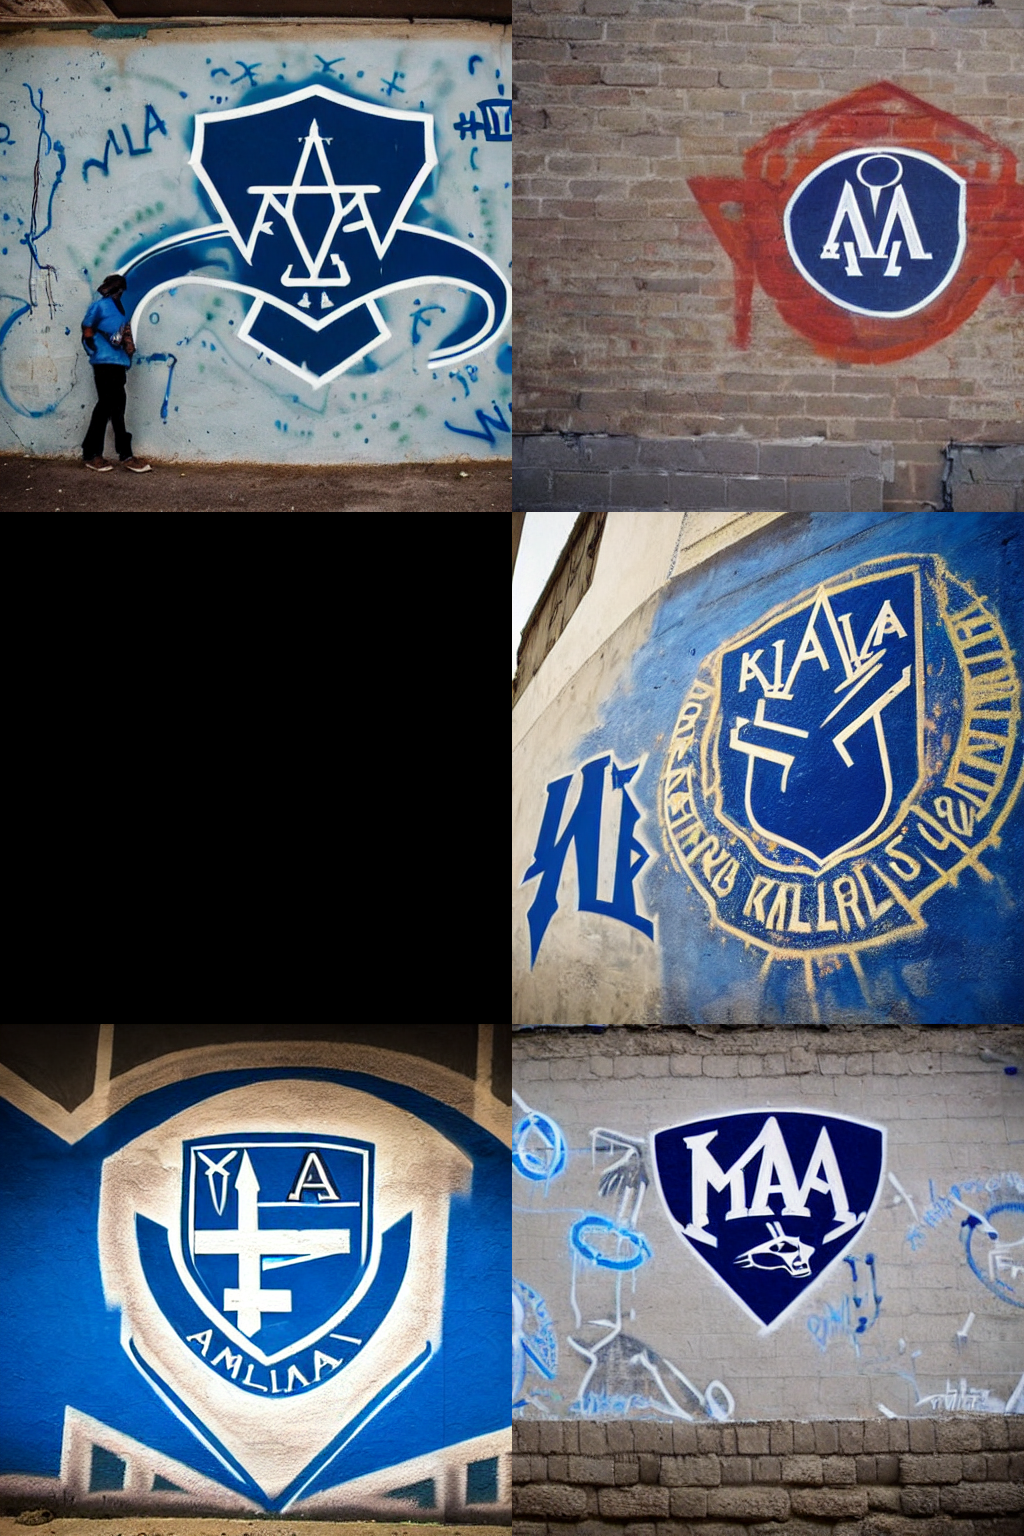

In [67]:
#@title Запустите Stable Diffusion pipeline
#@markdown Не забудьте использовать placeholder token в подсказке

prompt = "a grafitti in a wall with a \u003Cmai-logo> on it" #@param {type:"string"}

num_samples = 3 #@param {type:"number"}
num_rows = 2 #@param {type:"number"}

all_images = [] 
for _ in range(num_rows):
    images = pipe([prompt] * num_samples, num_inference_steps=50, guidance_scale=7.5).images
    all_images.extend(images)

grid = image_grid(all_images, num_samples, num_rows)
grid